# import packages and load data

In [1]:
import rmsp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, max_error

import sys
sys.path.append('../python_modules/')  # Defining the path to my modules
from hyperparameter_tunning import RandomSearch_KF, GridSearch_KF
from conditional_distributions import ConditionalMG, ConditionalML
from evaluation import AccuracyEvaluator

# load data

In [2]:
# Loading data as we would with a "real" csv file
data = pd.read_csv('wl_semisyn_bivariate.csv')
# data_orig['z'] = 0

# Converting Pandas Dataframe into a RMSP Point Data
data = rmsp.PointData(data, x='x', y="y")
data.drop('x1_shift', axis=1, inplace=True)
data.rename(columns={'x1':'var1', 'tg':'var2'}, inplace=True)

type(data)

rmsp.core.point.PointData

# sub-sampling and splitting data

In [3]:
# Define threshold on the reference variable
thr_var = 'var1'
threshold = data[thr_var].quantile(0.50)

# fractions to select as "complete"
frac_above = 0.60
frac_below = 0.40

# Select samples above and below the median threshold
samples_above_threshold = data[data[thr_var] > threshold]
samples_below_threshold = data[(data[thr_var] < threshold)]

# Sample subsets
complete_set_above = samples_above_threshold.sample(frac=frac_above, random_state=42)
complete_set_below = samples_below_threshold.sample(frac=frac_below, random_state=42)

# Combine subsets
complete_set = pd.concat([complete_set_above, complete_set_below])

# Remaining samples (excluding complete set) go to missing set
missing_set = data.drop(complete_set.index)

# Split the "complete" subset into validation and modeling subsets
valid_set = complete_set.sample(frac=0.15, random_state=42)
model_set = complete_set.drop(valid_set.index)

# Create flags in the main dataframe
data['missing'] = 0
data['valid'] = 0
data['model'] = 0
data.loc[missing_set.index, 'missing'] = 1
data.loc[valid_set.index,   'valid']   = 1
data.loc[model_set.index,   'model']   = 1

# nscore

In [4]:
# Instantiate transformers
nscorer_var1 = rmsp.NSTransformer(warn_no_wt=False)
nscorer_var2 = rmsp.NSTransformer(warn_no_wt=False)

# Fit and transform predictor
nscorer_var1.fit(model_set['var1'])
model_set['ns_var1'] = nscorer_var1.transform(model_set['var1'])
valid_set['ns_var1'] = nscorer_var1.transform(valid_set['var1'])

# Fit and transform target
nscorer_var2.fit(complete_set['var2'])
model_set['ns_var2'] = nscorer_var2.transform(model_set['var2'])
valid_set['ns_var2'] = nscorer_var2.transform(valid_set['var2'])

# fit the model

In [5]:
# Create model instance
model_mg = ConditionalMG()

# fitting
model_mg.fit(model_set[['ns_var1']].values, model_set['ns_var2'].values)

# Predicting missing data
means_mg, _, _ = model_mg.predict(valid_set['ns_var1'].values)

# # Checking
# mse_mg = mean_squared_error(valid_set['ns_var2'].values, means_mg)
# rmse_mg = np.sqrt(mse_mg)
# r2_mg = r2_score(valid_set['ns_var2'].values, means_mg)

# # Printing results
# print(f'RMSE calculated on validation data: {np.round(rmse_mg, 4)}')
# print(f'R2 calculated on validation data: {np.round(r2_mg, 4)}')

In [6]:
# Create model instance
model_ml_tsr2 = ConditionalML(
    regressor=GradientBoostingRegressor,
    r_squared=0.5591,
    reg_hyperparams={'alpha': 0.9,
                     'ccp_alpha': 0.0,
                     'criterion': 'friedman_mse',
                     'init': None,
                     'learning_rate': 0.05,
                     'loss': 'squared_error',
                     'max_depth': 2,
                     'max_features': None,
                     'max_leaf_nodes': None,
                     'min_impurity_decrease': 0.0,
                     'min_samples_leaf': 4,
                     'min_samples_split': 4,
                     'min_weight_fraction_leaf': 0.0,
                     'n_estimators': 100,
                     'n_iter_no_change': None,
                     'random_state': 42,
                     'subsample': 0.8,
                     'tol': 0.0001,
                     'validation_fraction': 0.1,
                     'verbose': 0,
                     'warm_start': False}
)

# fitting
model_ml_tsr2.fit(model_set[['ns_var1']].values, model_set['ns_var2'].values)

In [7]:
# Create model instance
model_ml_trr2 = ConditionalML(
    regressor=GradientBoostingRegressor,
    r_squared=0.7907,
    reg_hyperparams={'alpha': 0.9,
                     'ccp_alpha': 0.0,
                     'criterion': 'friedman_mse',
                     'init': None,
                     'learning_rate': 0.05,
                     'loss': 'squared_error',
                     'max_depth': 2,
                     'max_features': None,
                     'max_leaf_nodes': None,
                     'min_impurity_decrease': 0.0,
                     'min_samples_leaf': 4,
                     'min_samples_split': 4,
                     'min_weight_fraction_leaf': 0.0,
                     'n_estimators': 100,
                     'n_iter_no_change': None,
                     'random_state': 42,
                     'subsample': 0.8,
                     'tol': 0.0001,
                     'validation_fraction': 0.1,
                     'verbose': 0,
                     'warm_start': False}
)

# fitting
model_ml_trr2.fit(model_set[['ns_var1']].values, model_set['ns_var2'].values)

In [8]:
# Create model instance
model_ml_opr2 = ConditionalML(
    regressor=GradientBoostingRegressor,
    r_squared=0.7275,
    reg_hyperparams={'alpha': 0.9,
                     'ccp_alpha': 0.0,
                     'criterion': 'friedman_mse',
                     'init': None,
                     'learning_rate': 0.05,
                     'loss': 'squared_error',
                     'max_depth': 2,
                     'max_features': None,
                     'max_leaf_nodes': None,
                     'min_impurity_decrease': 0.0,
                     'min_samples_leaf': 4,
                     'min_samples_split': 4,
                     'min_weight_fraction_leaf': 0.0,
                     'n_estimators': 100,
                     'n_iter_no_change': None,
                     'random_state': 42,
                     'subsample': 0.8,
                     'tol': 0.0001,
                     'validation_fraction': 0.1,
                     'verbose': 0,
                     'warm_start': False}
)

# fitting
model_ml_opr2.fit(model_set[['ns_var1']].values, model_set['ns_var2'].values)

# evaluate using VALIDATION set

### Predict

In [9]:
# Predicting
means_mg, variances_mg, quantiles_mg, pdfs_mg, p_ranges_mg = model_mg.predict(valid_set[['ns_var1']].values, return_pdf=True)
means_ml_opr2, variances_ml_opr2, quantiles_ml_opr2, pdfs_ml_opr2, p_ranges_ml_opr2 = model_ml_opr2.predict(valid_set[['ns_var1']].values, return_pdf=True)
means_ml_tsr2, variances_ml_tsr2, quantiles_ml_tsr2, pdfs_ml_tsr2, p_ranges_ml_tsr2 = model_ml_tsr2.predict(valid_set[['ns_var1']].values, return_pdf=True)
means_ml_trr2, variances_ml_trr2, quantiles_ml_trr2, pdfs_ml_trr2, p_ranges_ml_trr2 = model_ml_trr2.predict(valid_set[['ns_var1']].values, return_pdf=True)

In [10]:
# Checking linear regression
mae_mg = max_error(valid_set['ns_var2'].values, means_mg)
mse_mg = mean_squared_error(valid_set['ns_var2'].values, means_mg)
rmse_mg = np.sqrt(mse_mg)
r2_mg = r2_score(valid_set['ns_var2'].values, means_mg)

# Printing results
print(f'MAE calculated on validation data: {np.round(mae_mg, 4)}')
print(f'RMSE calculated on validation data: {np.round(rmse_mg, 4)}')
print(f'R2 calculated on validation data: {np.round(r2_mg, 4)}')
print(f'Avg cond var calculated on validation data: {np.round(variances_mg.mean(), 4)}')

MAE calculated on validation data: 2.8761
RMSE calculated on validation data: 1.0445
R2 calculated on validation data: -0.0181
Avg cond var calculated on validation data: 0.9797


In [11]:
# Checking ml model
mae_ml = max_error(valid_set['ns_var2'].values, means_ml_opr2)
mse_ml = mean_squared_error(valid_set['ns_var2'].values, means_ml_opr2)
rmse_ml = np.sqrt(mse_ml)
r2_ml = r2_score(valid_set['ns_var2'].values, means_ml_opr2)

# Printing results
print(f'MAE calculated on validation data: {np.round(mae_ml, 4)}')
print(f'RMSE calculated on validation data: {np.round(rmse_ml, 4)}')
print(f'R2 calculated on validation data: {np.round(r2_ml, 4)}')
print(f'Avg cond var calculated on validation data: {np.round(variances_ml_opr2.mean(), 4)}')

MAE calculated on validation data: 1.4175
RMSE calculated on validation data: 0.5225
R2 calculated on validation data: 0.7453
Avg cond var calculated on validation data: 0.2725


In [12]:
df_results = pd.DataFrame({
    "MAE": [np.round(mae_ml, 4), np.round(mae_mg, 4)],
    "RMSE": [np.round(rmse_ml, 4), np.round(rmse_mg, 4)],
    "R2": [np.round(r2_ml, 4), np.round(r2_mg, 4)],
    "Avg cond var": [np.round(variances_ml_opr2.mean(), 4), np.round(variances_mg.mean(), 4)]
},
index=["ML Model", "Linear Regression"])

df_results

,MAE,RMSE,R2,Avg cond var
ML Model,1.4175,0.5225,0.7453,0.2725
Linear Regression,2.8761,1.0445,-0.0181,0.9797


# PLOT distributions

## define sample index

In [13]:
sample_index = 387

In [14]:
valid_set.nsmallest(5, 'ns_var1').index

Int64Index([0, 603, 575, 526, 714], dtype='int64')

In [15]:
valid_set.nlargest(5, 'ns_var1').index

Int64Index([166, 198, 162, 636, 387], dtype='int64')

In [16]:
valid_set.nlargest(33, 'ns_var1').index

Int64Index([166, 198, 162, 636, 387, 274, 511, 436, 598,  32, 275, 135, 452,
            435,  39, 484,   9, 325, 570, 693, 204,  96, 563,  33, 339, 610,
            815, 557, 770, 397, 382,  70, 671],
           dtype='int64')

In [17]:
valid_set.index.get_loc(387)

23

In [18]:
sample_index = 23

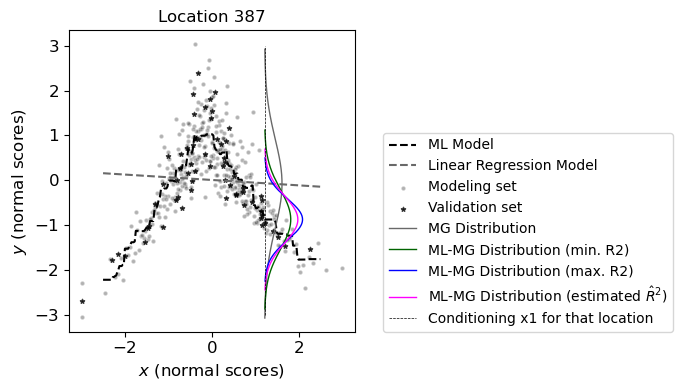

In [19]:
# Create scatter plot
plt.figure(figsize=(7.2, 4))

# Create values between -3 and +3
x_range = np.linspace(-2.5, 2.5, 200).reshape(-1, 1)  # shape (200, 1)

# Predict target variable values (might need to reshape or preprocess x_range)
y_pred_range_ml, _, _ = model_ml_opr2.predict(x_range)
y_pred_range_lr, _, _ = model_mg.predict(x_range)

# Line: Prediction for x1 in [-3, 3]
plt.plot(x_range, y_pred_range_ml, color='black', linewidth=1.5, linestyle='--', label='ML Model')
plt.plot(x_range, y_pred_range_lr, color='dimgrey', linewidth=1.5, linestyle='--', label='Linear Regression Model')

# Plot conditioning data
plt.scatter(model_set['ns_var1'], model_set['ns_var2'],alpha=0.3, s=10, color='black', label='Modeling set', edgecolors='white')

# Plot validation set's true values
plt.scatter(valid_set['ns_var1'], valid_set['ns_var2'],alpha=0.7, s=10, color='black', marker='*', label='Validation set')

# Distributions
plt.plot(pdfs_mg[sample_index]+valid_set['ns_var1'].iloc[sample_index], p_ranges_mg[sample_index],label='MG Distribution', color='dimgrey', linestyle='-', linewidth=1.0)
plt.plot(pdfs_ml_tsr2[sample_index]+valid_set['ns_var1'].iloc[sample_index], p_ranges_ml_tsr2[sample_index],label='ML-MG Distribution (min. R2)', color='darkgreen', linestyle='-', linewidth=1.0)
plt.plot(pdfs_ml_trr2[sample_index]+valid_set['ns_var1'].iloc[sample_index], p_ranges_ml_trr2[sample_index],label='ML-MG Distribution (max. R2)', color='blue', linestyle='-', linewidth=1.0)
plt.plot(pdfs_ml_opr2[sample_index]+valid_set['ns_var1'].iloc[sample_index], p_ranges_ml_opr2[sample_index],label=r'ML-MG Distribution (estimated $\hat{R}^2$)', color='magenta', linestyle='-', linewidth=1.0)

location = valid_set['ns_var1'].index[sample_index]
plt.vlines(x=valid_set['ns_var1'].iloc[sample_index], ymin=-3.0, ymax=3.0, linestyles='--', linewidth=0.5, colors='black', label='Conditioning x1 for that location')

# Labels

plt.title(f'Location {location}', fontsize=12)
plt.xlabel('$\mathit{x}$ (normal scores)', fontsize=12)
plt.ylabel('$\mathit{y}$ (normal scores)', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Legend
plt.legend(loc=[1.1,0])

# Layout and display
plt.tight_layout()
plt.show()